<h1> Polynomial Chaos 101

In [1]:
%matplotlib inline
from effective_quadratures.parameter import Parameter
from effective_quadratures.polynomial import Polynomial
from effective_quadratures.indexset import IndexSet
from effective_quadratures.computestats import Statistics
from effective_quadratures.utils import meshgrid, twoDgrid, evalfunction
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Assume we have a computational model -- in this case Rosenbrock's function -- that has two uncertainties. Thus
$$f(x_1, x_2) = (1 - x_1)^2 + 100(x_1 - x_2^2)^2$$
where
$x_1$ and $x_2$ are Gaussians with $\mu=1$ and $\sigma=2$. Our objective is to compute the mean and variance in the output $f$: $\mu(f)$ and $\sigma(f)$. Ok cool -- let's begin!

We start by defining our computational model, and call it fun(x)

In [2]:
def rosenbrock_fun(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

Next, we set the number of evaluation points in each direction. Lets opt for 4 points in the first direction $(x_1)$ and 7 points in the second direction $(x_2)$. Using a tensor grid, this results in 28 points.

In [3]:
no_pts_x1 = 5
no_pts_x2 = 5
mu = 1
sigma = 2
variance = sigma**2
x1 = Parameter(param_type="Gaussian", shape_parameter_A=mu, shape_parameter_B=variance, points=no_pts_x1)
x2 = Parameter(param_type="Gaussian", shape_parameter_A=mu, shape_parameter_B=variance, points=no_pts_x2)
parameters = [x1, x2]

Now, just to be sure we are getting the right distributions, we can plot the Gaussian (with 300 points):

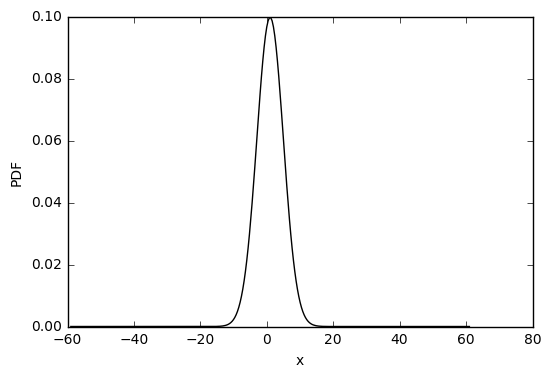

In [4]:
x, w = x1.getPDF(N=300, graph=1)

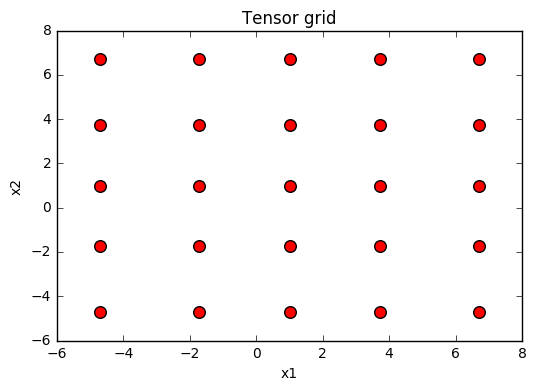

In [5]:
basis = IndexSet('Tensor grid',[no_pts_x1, no_pts_x2])
uqProblem = Polynomial(parameters, basis)
pts, wts = uqProblem.getPointsAndWeights()
# Now plot the points!
plt.scatter(pts[:,0], pts[:,1], s=70, c='r', marker='o');
plt.xlabel('x1');
plt.ylabel('x2');
plt.title('Tensor grid');

Now, we evaluate Rosenbrocks function at these points and compute the pseudospectral coefficients:

In [6]:
coefficients, indices, not_used = uqProblem.getPolynomialCoefficients(rosenbrock_fun)

# Create an instance of the Statistics class
stats = Statistics(coefficients, indices)
mean =  stats.getMean()
variance = stats.getVariance()

We wrap up with some print statements:

In [7]:
print 'MEAN & VARIANCE:'
print str(mean)+'\t'+str(variance)

MEAN & VARIANCE:
6804.0	476659232.0


Now we compare this result with brute-force Monte Carlo.

In [8]:
large_number = 200000
s = sigma * np.random.randn(large_number,2) + mu
f = np.zeros((large_number,1))
for i in range(0, large_number):
    f[i,0] = rosenbrock_fun([s[i,0], s[i,1]])

In [9]:
print 'MONTE CARLO MEAN & VARIANCE:'
print str(np.mean(f))+'\t'+str(np.var(f))

MONTE CARLO MEAN & VARIANCE:
6734.79522879	445505813.273


They seem pretty close! yay! Now we can do the same using a sparse grid using the sparse pseudospectral approximation method. The steps above remain the same with the exception of the choice of method:

In [10]:
basis = IndexSet("Sparse grid", level=4, growth_rule='linear', dimension=2)
uqProblem = Polynomial(parameters, basis)

Now lets plot the points associated with this sparse grid

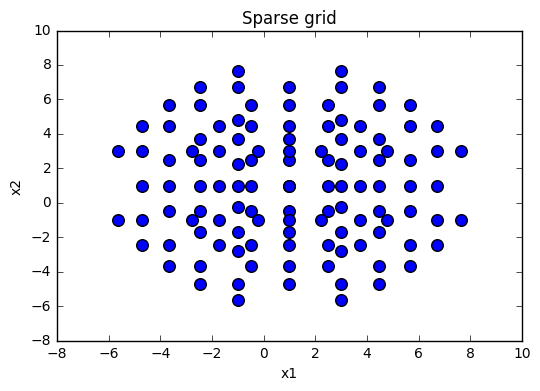

In [11]:
coefficients, index_set, pts = uqProblem.getPolynomialCoefficients(rosenbrock_fun)
plt.scatter(pts[:,0], pts[:,1], s=70, c='b', marker='o');
plt.xlabel('x1');
plt.ylabel('x2');
plt.title('Sparse grid');
plt.savefig('destination_path.png', format='png', dpi=500)

And we can also visualize the coefficients. 

(0, 6)

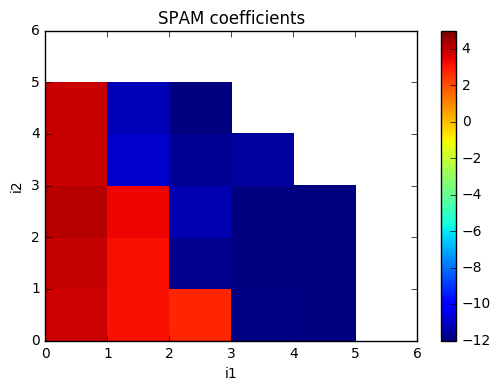

In [12]:
x,y,z, max_order = twoDgrid(coefficients, index_set)
z = np.log10(np.abs(z))

# Plot of the pseudospectral coefficients
Zm = np.ma.masked_where(np.isnan(z),z)
plt.pcolor(y,x, Zm, cmap='jet', vmin=-12, vmax=5)
plt.title('SPAM coefficients')
plt.xlabel('i1')
plt.ylabel('i2')
plt.colorbar()
plt.xlim(0,max_order)
plt.ylim(0,max_order)

And finally we compute the mean and variance use the sparse pseudospectral approximation method. Note the code is identical to the tensor grid case, with the exception of our new definition for "uqProblem":

In [13]:
# Create an instance of the Statistics class
stats = Statistics(coefficients, index_set)
mean =  stats.getMean()
variance = stats.getVariance()
print 'MEAN & VARIANCE:'
print str(mean)+'\t'+str(variance)

MEAN & VARIANCE:
6804.0	476659232.0
